<a href="https://colab.research.google.com/github/ViniciusSilveiraCampos/Classificador-De-Imagens/blob/main/Rede_Neural_Convolucional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTAÇÃO DAS BIBLIOTECAS

In [66]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
torch.__version__

'2.1.0+cu121'

## BASE DE DADOS

In [67]:
torch.manual_seed(123)

In [203]:
transform = transforms.Compose(
    [
     transforms.Resize([32, 32]),
     transforms.ToTensor()
    ]
)

In [204]:
train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]], dtype=uint8)
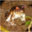

In [205]:
train.data[0]

In [206]:
train.data.shape

(50000, 32, 32, 3)

In [208]:
set(train.targets)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [209]:
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128)

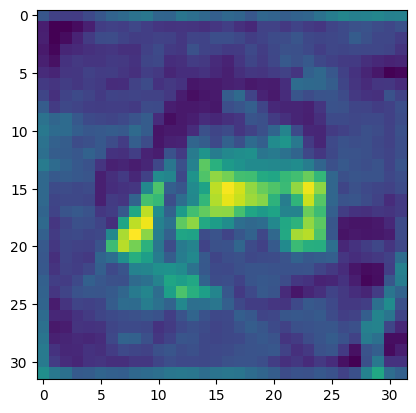

In [235]:
imagem = next(iter(train))[0][2].view(32, 32) # (1, 1, 28, 28)
plt.imshow(imagem)

In [211]:
imagem.shape

torch.Size([1, 3, 28, 28])

## CONSTRUÇÃO DO MODELO

In [214]:
class classificador(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3))
    self.conv2 = nn.Conv2d(32, 32, (3, 3))
    self.activation = nn.ReLU()
    self.bnorm = nn.BatchNorm2d(num_features=32)
    self.pool = nn.MaxPool2d(kernel_size = (2,2))
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(in_features=32*6*6, out_features=128)
    self.linear2 = nn.Linear(128, 128)
    self.output = nn.Linear(128, 10)
    self.dropout = nn.Dropout(p = 0.2)

  def forward(self, X):
    X = self.pool(self.bnorm(self.activation(self.conv1(X))))
    X = self.pool(self.bnorm(self.activation(self.conv2(X))))
    X = self.flatten(X)

    X = self.dropout(self.activation(self.linear1(X)))
    X = self.dropout(self.activation(self.linear2(X)))
    X = self.output(X)

    return X

In [215]:
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

## TREINAMENTO DO MODELO

In [216]:
device = torch.device('cuda') if torch.cuda.is_available else torch.devide('cpu')
device

device(type='cuda')

In [217]:
net.to(device)

classificador(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1152, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [218]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.

    for i, data in enumerate(loader):
        inputs, labels = data

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        ps = F.softmax(outputs)
        top_p, top_class = ps.topk(k = 1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)

        accuracy = torch.mean(equals.type(torch.float))

        running_accuracy += accuracy


        print(f'Época {epoch+1} - Loop {i+1} de {len(loader)}: perda {loss} - precisão {accuracy}')

    print(f'ÉPOCA {epoch+1} FINALIZADA: perda {running_loss/len(loader)} - precisão {running_accuracy/len(loader)}')

In [219]:
for epoch in range(5):
  print('Treinando...')
  training_loop(train_loader, epoch)
  net.eval()
  print('Validando...')
  training_loop(test_loader, epoch)
  net.train()

Treinando...


<ipython-input-218-0aacad5ca21f>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ps = F.softmax(outputs)


ÉPOCA   1 FINALIZADA: perda 1.38725 - precisão 0.49962
Validando...
ÉPOCA   1 FINALIZADA: perda 1.55581 - precisão 0.45659
Treinando...
ÉPOCA   2 FINALIZADA: perda 1.06840 - precisão 0.62397
Validando...
ÉPOCA   2 FINALIZADA: perda 1.27038 - precisão 0.55014
Treinando...
ÉPOCA   3 FINALIZADA: perda 0.92756 - precisão 0.67570
Validando...
ÉPOCA   3 FINALIZADA: perda 1.14649 - precisão 0.58762
Treinando...
ÉPOCA   4 FINALIZADA: perda 0.83118 - precisão 0.70866
Validando...
ÉPOCA   4 FINALIZADA: perda 0.99955 - precisão 0.64903
Treinando...
ÉPOCA   5 FINALIZADA: perda 0.75570 - precisão 0.73523
Validando...
ÉPOCA   5 FINALIZADA: perda 0.93765 - precisão 0.67128


## AVALIAÇÃO DO MODELO

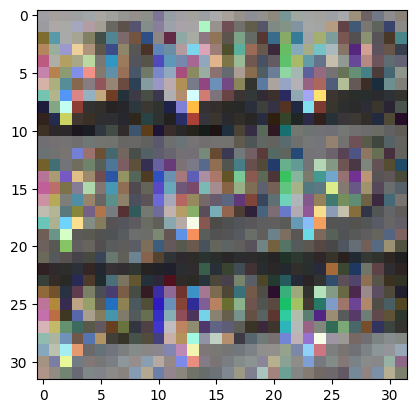

In [221]:
imagem = next(iter(test_loader))[0][0].view(32,32,3)
plt.imshow(imagem, cmap='gray')

In [224]:
imagem = imagem.view(1, 3, 32, 32)

torch.Size([1, 3, 32, 32])

In [225]:
net.eval()
imagem = imagem.to(device)

In [226]:
previsao = net.forward(imagem)

In [227]:
previsao

tensor([[-0.4583, -1.7384, -0.7404,  1.6209, -1.1843,  0.7675, -0.3079, -0.9798,
         -0.8855, -1.4358]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [228]:
previsao = F.softmax(previsao)

<ipython-input-228-4836b3525bc1>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  previsao = F.softmax(previsao)


In [229]:
previsao

tensor([[0.0599, 0.0166, 0.0451, 0.4788, 0.0290, 0.2039, 0.0696, 0.0355, 0.0390,
         0.0225]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [230]:
previsao = previsao.cpu().detach().numpy()

In [231]:
previsao

array([[0.05986118, 0.01664232, 0.04514685, 0.4787557 , 0.02896348,
        0.20394735, 0.06957385, 0.03553607, 0.03904945, 0.02252372]],
      dtype=float32)

In [232]:
resultado = np.argmax(previsao)

In [237]:
print(f'O resultado das {test.targets[0]}')

3

In [233]:
resultado

3